# Import and initialize

## Importing modules

In [297]:
%matplotlib notebook

from IPython.display import clear_output

import sys
sys.path.append(r"D:\OneDrive\BF3\Code");
sys.path.append(r"D:\OneDrive\BF3\Code\labtools-master")

import os
import time
import datetime
import numpy as np
import matplotlib as mpl
# import utils

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

# from labtools import mplplots; reload(mplplots)
# from labtools.mplplots.init_nb_plotting import *
# from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.database import initialise_database, get_DB_location

qc.config.subscription.default_subscribers  = ["Plottr"] # use plottr as the live plotting tool

from qcodes import new_experiment, Station, Instrument
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.data_export import get_data_by_id

from pytopo.qctools import instruments as instools

#from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path

# from MDAC import MDAC 
# from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A

#from qcodes.instrument_drivers.stanford_research.SR860 import SR860
#from qcodes.instrument_drivers.QuTech.IVVI import IVVI
#from qcodes.instrument_drivers.yokogawa.GS200 import GS200

from pytopo.sweep import sweep, measure, nest, chain, szip, getter, setter, time_trace, do_experiment
from pytopo.qctools.instruments import create_inst

## Database configuration

In [2]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [291]:
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\experiments_%Y-%m-%d.db')
# automatically uses a different DB file for each month
initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

Upgrading database: : 0it [00:00, ?it/s]


In [231]:
qc.config.subscription.default_subscribers = ["Plottr"]

## Wiring check

In [5]:
sys.path.append(r"D:\OneDrive\BF3\Code\BF3")
from QT3_PCB.pad_conversion import Gen5_to_BoB

In [6]:
Gen5_to_BoB(45,11,17,15,32)

pad 45 is matrix element(3, 15)
pad 11 is matrix element(4, 20)
pad 17 is matrix element(4, 17)
pad 15 is matrix element(4, 18)
pad 32 is matrix element(3, 9)


[(3, 15), (4, 20), (4, 17), (4, 18), (3, 9)]

## Initialize instruments

### DC

In [4]:
station = Station()

sys.path.append(r"D:\OneDrive\BF3\Code\StationQ\MDAC\Driver")
from MDAC import MDAC
mdac = MDAC('MDAC1', 'ASRL4::INSTR', debug=False, logging=False)

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
key1 = create_inst(Keysight_34465A, "key1", "USB0::0x2A8D::0x0301::MY57505052::INSTR", force_new_instance=True)
#key2 = create_inst(Keysight_34465A, "key2", "USB0::0x2A8D::0x0101::MY57503135::INSTR", force_new_instance=True)

from qcodes.instrument_drivers.stanford_research.SR865 import SR865
lockin1 = create_inst(SR865, "lockin1", "GPIB0::4::INSTR")
lockin1.amplitude.vals._min_value = 0

station = qc.Station(mdac, key1, lockin1)

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\ctwrapper\functions.py:1649: VisaIOWarning: VI_WARN_NSUP_ATTR_STATE (1073676420): Although the specified state of the attribute is valid, it is not supported by this implementation.
  return library.viSetAttribute(session, attribute, attribute_state)


Connected to: QNL Sydney MDAC (serial:0x32353532353551040028003E, firmware:1.4) in 2.74s
Connected to: Keysight Technologies 34465A (serial:MY57505052, firmware:A.02.16-02.40-02.16-00.51-03-01) in 0.20s
Connected to: Stanford_Research_Systems SR860 (serial:003225, firmware:V1.47) in 0.11s


In [5]:
print('lockin1 excitation amplitude =', lockin1.amplitude(), 'V')
print('lockin1 DC bias =', lockin1.sine_outdc(), 'V')
print('lockin1 frequency =', lockin1.frequency(), 'Hz')
print('lockin1 phase =', lockin1.phase(), 'deg')
print('lockin1 X =', lockin1.X(), 'V')
print('lockin1 Y =', lockin1.Y(), 'V')
print('lockin1 R =', lockin1.R(), 'V')
print('lockin1 P =', lockin1.P(), 'deg')

lockin1 excitation amplitude = 0.0 V
lockin1 DC bias = -1.018634066e-10 V
lockin1 frequency = 77.792 Hz
lockin1 phase = -0.00099996104836 deg
lockin1 X = 3.1208620044e-07 V
lockin1 Y = -3.7914142581e-07 V
lockin1 R = 5.2268342188e-07 V
lockin1 P = -49.522102356 deg


In [301]:
from qcodes.instrument_drivers.Lakeshore import Model_372
ls = instools.create_inst(Model_372.Model_372, 'lakeshore_372', 'TCPIP::192.168.0.160::7777::SOCKET')
h = ls.sample_heater

VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

### Magnet

Check that the magnet is the "right" one and so the parameters (coil constant and so on...)

In [ ]:
ami_x = instools.create_inst(AMI430, "AMI430_x", "192.168.0.157", port = 7180, has_current_rating=True)
ami_y = instools.create_inst(AMI430, "AMI430_y", "192.168.0.158", port = 7180, has_current_rating=True)
ami_z = instools.create_inst(AMI430, "AMI430_z", "192.168.0.159", port = 7180, has_current_rating=True)

ramp_limit_multiplier = 0.6
ami_x.current_ramp_limit(0.1802*ramp_limit_multiplier)
ami_x.coil_constant(0.01466)
ami_x.current_rating(68.21)

ami_y.current_ramp_limit(0.1784*ramp_limit_multiplier)
ami_y.coil_constant(0.01464)
ami_y.current_rating(68.31)

ami_z.current_ramp_limit(0.0775*ramp_limit_multiplier)
ami_z.coil_constant(0.0818)
ami_z.current_rating(73.35)

ami = instools.create_inst(AMI430_3D, "AMI430", ami_x, ami_y, ami_z, 2)
ami_3d = AMI430_3D("AMI_3D", ami_x, ami_y, ami_z, 1);

### RF

## Measurement functions

In [10]:
gate_ramp_stepsize = 1e-3  #[V]
gate_ramp_delay = 0.01  #[s]

def ramp(param, target, step_size, delay): 
    current_value = param()
    step_size *= np.sign(target - current_value)
    if abs(step_size) < 1E-10: 
        return 
    
    steps = np.arange(current_value, target, step_size)
    for step in steps: 
        param(step)
        time.sleep(delay)
    
    param(target)
    
def set_mdac_in_safemode(nchan=64):
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    lockin1.amplitude(0)
    lockin1.sine_outdc(0)
    
    print('setting mdac in safe mode')
    
    for ch in mdac.channels[:nchan]:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

    # Note: we do this in separate loops because we want to be sure that
    # no currents are running anywhere before switching the relays
    for ch in mdac.channels[:nchan]:
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
        #ch.divider('off')
    print('Done')

def chs_safe(*channels):
    lockin1.amplitude(0)
    lockin1.sine_outdc(0)   
    print('setting mdac in safe mode')
    for ch in channels:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
    print('Done')

In [41]:
gate_ramp_stepsize = 1e-3  #[V]
gate_ramp_delay = 0.01  #[s]


def mdac_PG_voltage_raw(voltage): 
    ramp(PG.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_PG_voltage = setter(("mdac_PG_voltage", "V"))(mdac_PG_voltage_raw)

def mdac_TG1_voltage_raw(voltage): 
    ramp(TG1.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_TG1_voltage = setter(("mdac_TG1_voltage", "V"))(mdac_TG1_voltage_raw)

def mdac_TG2_voltage_raw(voltage): 
    ramp(TG2.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)
mdac_TG2_voltage = setter(("mdac_TG2_voltage", "V"))(mdac_TG2_voltage_raw)


bias_ramp_stepsize = 1e-3  #[V], lockin DIRECT output DC value
bias_ramp_delay = 0.01  #[s]

@setter(("mdac_bias_voltage", "V"))
def mdac_bias_voltage(voltage): 
    voltage *= 790
    ramp(source.voltage, voltage, bias_ramp_stepsize, bias_ramp_delay)

@setter(("lockin_dc", "V"))
def lockin_dc(voltage): 
    voltage *= 100
    ramp(lockin1.sine_outdc, voltage, bias_ramp_stepsize, bias_ramp_delay)

@setter(("yoko2_voltage", "V"))
def yoko2_voltage(voltage): 
    #voltage *= 790
    ramp(yoko2.voltage, voltage, gate_ramp_stepsize, gate_ramp_delay)

@setter(("time_sweep", "a.u."))
def time_sweep(a): 
    time.sleep(0.001)
    
@setter(("datapoint", "a.u."))
def datapoint(a): 
    time.sleep(0)    
    
@setter(("field_sweep", "T"))
def field_sweep(a):
    time.sleep(0.001);

In [129]:
def initialize(*channels):
    for s in channels:
        ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
    #     ramp(g.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        s.smc('close')
        s.dac_output('close')
    #     d.gnd('close')
    #     g.dac_output('close')
    #     g.smc('close')
    
def initialize_leakage(channels_to_close, channels_to_open):
    for s in channels_to_close:
        ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        s.smc('close')
        s.dac_output('close')
    for s in channels_to_open:
        ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        s.smc('open')
        s.dac_output('open')

# Measurements

In [218]:
set_mdac_in_safemode()

setting mdac in safe mode
Done


In [219]:
TG1 = mdac.ch58
PG = mdac.ch57
TG2 = mdac.ch59

initialize(PG,TG1,TG2)

In [295]:
initialize(PG,TG1,TG2)

## DC+lockin

In [293]:

def setup():
    #set_mdac_in_safemode()
    #chs_safe(gate)
    #initialize(PG,TG1)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_PG_voltage(2)
    mdac_TG1_voltage(0)
    #mdac_TG2_voltage(1.2)
    lockin_dc(10e-3)
    #gate.voltage(0.8)
#     key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    lockin1.amplitude(5e-4)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(3)

def cleanup(): 
    #pass
    lockin1.amplitude(0)
    lockin_dc(0)
    #chs_safe(gate)
    #set_mdac_in_safemode()   
    mdac_PG_voltage(0)
    mdac_TG1_voltage(0)
    #mdac_TG2_voltage(1.2)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)

@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e6, Rseries=13e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    #V_meas = key2.volt()
    if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        time.sleep(3)
        #print(sr1.X())
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    Vac     = adder_atten*lockin1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = lockin1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g = 0

    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

#gate_values = np.linspace(2, 3, 151)
#gate_values = np.linspace(0, -0.75, 3)
# gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
    "Q216F_TG_sweep_Bias_10mV_PG_2V/A27B5",
    nest(
        sweep(mdac_TG1_voltage, np.linspace(0, 2.5, 201)),
        #sweep(mdac_PG_voltage, np.linspace(1.6, 1.7, 101)),
        #sweep(lockin_dc, np.linspace(-1e-3, 1e-3, 201)), # real voltage applied onto device
        measure(measure_acdc)
    ),
    setup,
    cleanup,
    live_plot=True
)

d:\onedrive\bf3\code\plottr\plottr\tools.py:58: UserWarning: Failed to start listener!


Starting experimental run with id: 2
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Tim

In [286]:
for pg in np.linspace(-1, 1, 3):
    def setup():
        #set_mdac_in_safemode()
        #chs_safe(gate)
        #initialize(PG,TG1)
        #ami_z.field(5.5)
        #mdac.ch49.voltage(-3.5)
        #mdac.ch57.dac_output('close')
        #mdac.ch57.smc('close')
        key1.NPLC(1)
        #source.voltage(0.8) 
        #mdac_bias_voltage(5e-3)
        mdac_PG_voltage(pg)
        mdac_TG1_voltage(1.2)
        #mdac_TG2_voltage(1.2)
        lockin_dc(-1e-3)
        #gate.voltage(0.8)
    #     key2.NPLC(1)
        #ivvi.dac1(0)
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        lockin1.amplitude(5e-4)     # 1e-2 attenuation so 10uV excitation when this is 1mV
        #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
        #sr1.frequency(117)     # adder HPF cutoff is 15Hz
        #sr1.phase(0)
        #sr1.time_constant(.1)
        #ami_x.field(0)
        #ami_x.ramp_to(-0.2)
        time.sleep(3)

    def cleanup(): 
        #pass
        lockin1.amplitude(0)
        lockin_dc(0)
        #chs_safe(gate)
        #set_mdac_in_safemode()   
        mdac_PG_voltage(pg)
        mdac_TG1_voltage(1.2)
        #mdac_TG2_voltage(1.2)
        #mdac.ch57.dac_output('open')
        #mdac.ch57.smc('open')
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #ivvi.dac1(0)    
        #yoko2.voltage(0)
        #ami_x.field(0)
        #ami_z.field(0)

    @getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
            ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
            ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
    def measure_acdc(gain=1e6, Rseries=18e3, adder_atten=1e-2):
        time.sleep(0.08)
        #B_x = ami_x.field()
        #V_meas = key2.volt()
        if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
            #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
            time.sleep(3)
            #print(sr1.X())
        key_raw = key1.volt()
        current_dc = -key_raw/gain
        Vac     = adder_atten*lockin1.amplitude()  #*np.sqrt(2)
        #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
        L1P     = lockin1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
        L1R     = lockin1.R()
        L1Y     = lockin1.Y()
        # the above lines (excluding time.sleep) take at least 75ms to execute. 
        L1X     = lockin1.X()
        current_ac = L1X/gain    
        try:
            g = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
        except ZeroDivisionError:
            g = 0

        result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
        return result

    #gate_values = np.linspace(2, 3, 151)
    #gate_values = np.linspace(0, -0.75, 3)
    # gate_values = np.append(gate_values,gate_values[::-1])

    result = do_experiment(
        "Q216F_TGvsBias_PG_{:.2f}V/D33A2".format(pg),
        nest(
            sweep(mdac_TG1_voltage, np.linspace(1.2, 1.5, 201)),
            #sweep(mdac_PG_voltage, np.linspace(1.6, 1.7, 101)),
            sweep(lockin_dc, np.linspace(-1e-3, 1e-3, 201)), # real voltage applied onto device
            measure(measure_acdc)
        ),
        setup,
        cleanup,
        live_plot=True
    )

d:\onedrive\bf3\code\plottr\plottr\tools.py:58: UserWarning: Failed to start listener!


Starting experimental run with id: 9
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Tim

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during s

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during s

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during s

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during s

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during se

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during s

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during s

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during s

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during se

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during se

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during s

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during se

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during s

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during s

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during se

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during s

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during se

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during s

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during s

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during se

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during s

In [246]:
for pg in np.linspace(0.1,2,10):
    def setup():
        #set_mdac_in_safemode()
        #chs_safe(gate)
        #initialize(PG,TG1)
        #ami_z.field(5.5)
        #mdac.ch49.voltage(-3.5)
        #mdac.ch57.dac_output('close')
        #mdac.ch57.smc('close')
        key1.NPLC(1)
        #source.voltage(0.8) 
        #mdac_bias_voltage(5e-3)
        mdac_PG_voltage(pg)
        mdac_TG1_voltage(1)
        mdac_TG2_voltage(1)
        lockin_dc(10e-3)
        #gate.voltage(0.8)
    #     key2.NPLC(1)
        #ivvi.dac1(0)
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        lockin1.amplitude(10e-4)     # 1e-2 attenuation so 10uV excitation when this is 1mV
        #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
        #sr1.frequency(117)     # adder HPF cutoff is 15Hz
        #sr1.phase(0)
        #sr1.time_constant(.1)
        #ami_x.field(0)
        #ami_x.ramp_to(-0.2)
        time.sleep(3)

    def cleanup(): 
        #pass
        lockin1.amplitude(0)
        lockin_dc(0)
        #chs_safe(gate)
        #set_mdac_in_safemode()   
        mdac_PG_voltage(pg)
        mdac_TG1_voltage(1)
        mdac_TG2_voltage(1)
        #mdac.ch57.dac_output('open')
        #mdac.ch57.smc('open')
        #ivvi.dac3(0)
        #ivvi.dac2(0)
        #ivvi.dac1(0)    
        #yoko2.voltage(0)
        #ami_x.field(0)
        #ami_z.field(0)

    @getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
            ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
            ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
    def measure_acdc(gain=1e6, Rseries=13e3, adder_atten=1e-2):
        time.sleep(0.08)
        #B_x = ami_x.field()
        #V_meas = key2.volt()
        if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
            #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
            time.sleep(3)
            #print(sr1.X())
        key_raw = key1.volt()
        current_dc = -key_raw/gain
        Vac     = adder_atten*lockin1.amplitude()  #*np.sqrt(2)
        #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
        L1P     = lockin1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
        L1R     = lockin1.R()
        L1Y     = lockin1.Y()
        # the above lines (excluding time.sleep) take at least 75ms to execute. 
        L1X     = lockin1.X()
        current_ac = L1X/gain    
        try:
            g = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
        except ZeroDivisionError:
            g = 0

        result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
        return result

    #gate_values = np.linspace(2, 3, 151)
    #gate_values = np.linspace(0, -0.75, 3)
    # gate_values = np.append(gate_values,gate_values[::-1])

    result = do_experiment(
        "Q216F_TG1vsTG2_bias_10mV_PG_{:.2f}V/D28D31".format(pg),
        nest(
            sweep(mdac_TG1_voltage, np.linspace(1, 2, 71)),
            sweep(mdac_TG2_voltage, np.linspace(1, 2, 71)),
            #sweep(lockin_dc, np.linspace(-1e-3, 1e-3, 201)), # real voltage applied onto device
            measure(measure_acdc)
        ),
        setup,
        cleanup,
        live_plot=True
    )

d:\onedrive\bf3\code\plottr\plottr\tools.py:58: UserWarning: Failed to start listener!


Starting experimental run with id: 8
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Tim

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during s

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during s

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during s

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during s

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during se

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during s

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during s

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during se

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during se

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during s

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during s

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during se

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during s

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during se

Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during se

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!Timeout during sending!

Timeout during sending!Timeout during sending!

Timeout during s

In [192]:
def setup():
    #set_mdac_in_safemode()
    #chs_safe(gate)
    #initialize(PG,TG1)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_PG_voltage(0.25)
    mdac_TG1_voltage(1)
    mdac_TG2_voltage(1)
    lockin_dc(10e-3)
    #gate.voltage(0.8)
#     key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    lockin1.amplitude(10e-4)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(3)

def cleanup(): 
    #pass
    lockin1.amplitude(0)
    lockin_dc(0)
    #chs_safe(gate)
    #set_mdac_in_safemode()   
    mdac_PG_voltage(0.25)
    mdac_TG1_voltage(1)
    mdac_TG2_voltage(1)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e6, Rseries=13e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    #V_meas = key2.volt()
    if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        time.sleep(3)
        #print(sr1.X())
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    Vac     = adder_atten*lockin1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = lockin1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g = 0
        
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

#gate_values = np.linspace(2, 3, 151)
#gate_values = np.linspace(0, -0.75, 3)
# gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
    "Q216F_TG1vsTG2_bias_10mV_PG_0.25V/D28D31",
    nest(
        sweep(mdac_TG1_voltage, np.linspace(1, 2, 201)),
        sweep(mdac_TG2_voltage, np.linspace(1, 2, 201)),
        #sweep(lockin_dc, np.linspace(-1e-3, 1e-3, 201)), # real voltage applied onto device
        measure(measure_acdc)
    ),
    setup,
    cleanup,
    live_plot=True
)

Starting experimental run with id: 28


<IPython.core.display.Javascript object>


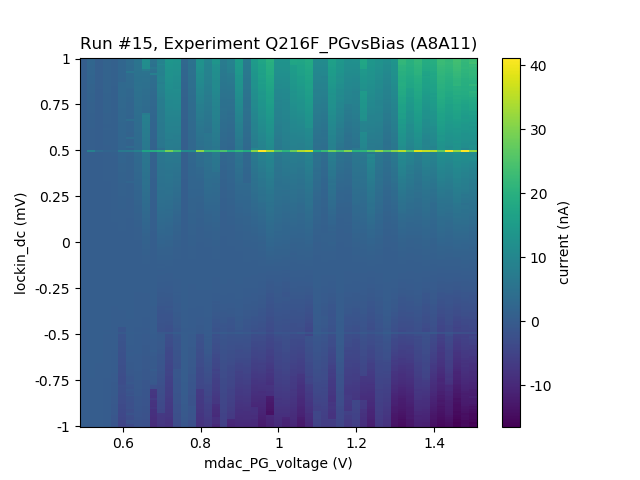

<IPython.core.display.Javascript object>


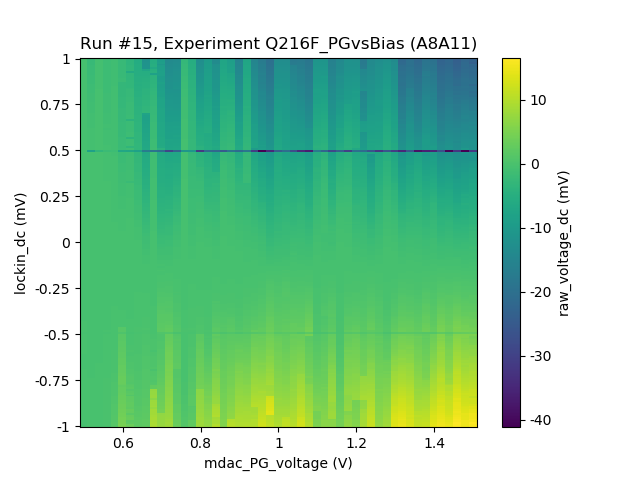

<IPython.core.display.Javascript object>


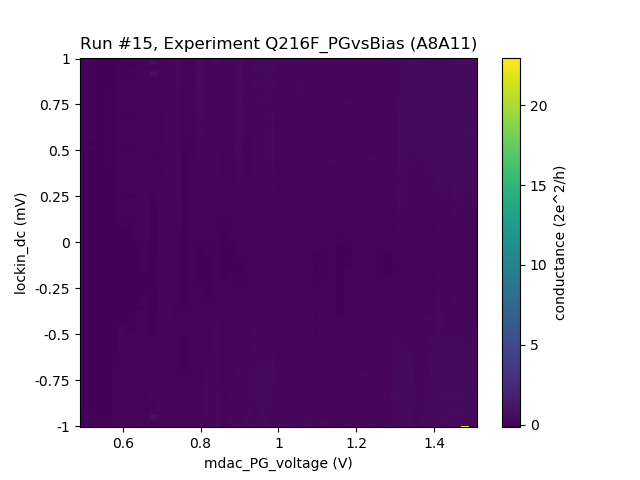

<IPython.core.display.Javascript object>


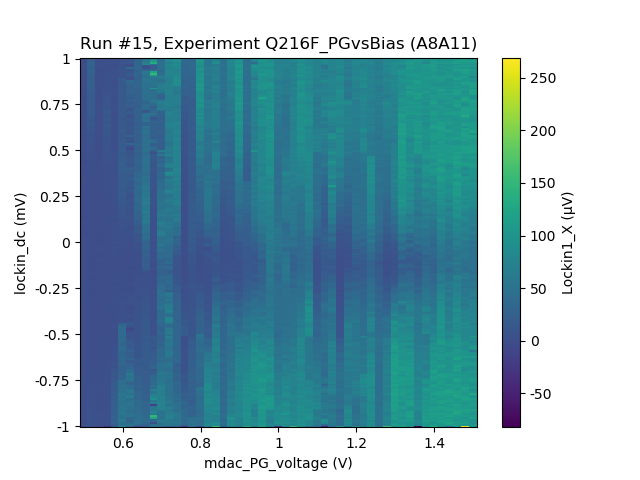

<IPython.core.display.Javascript object>


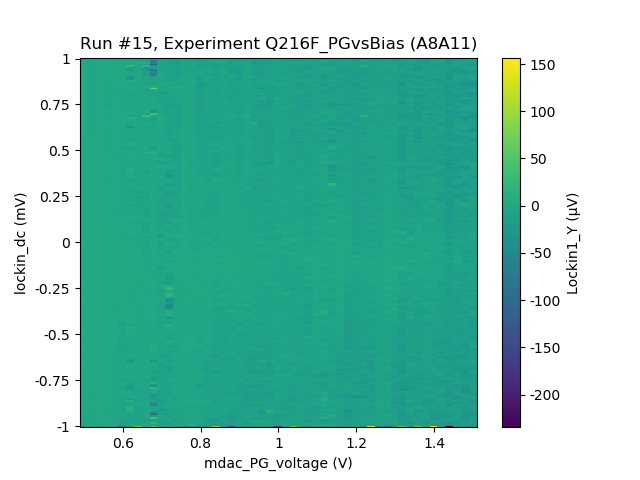

<IPython.core.display.Javascript object>


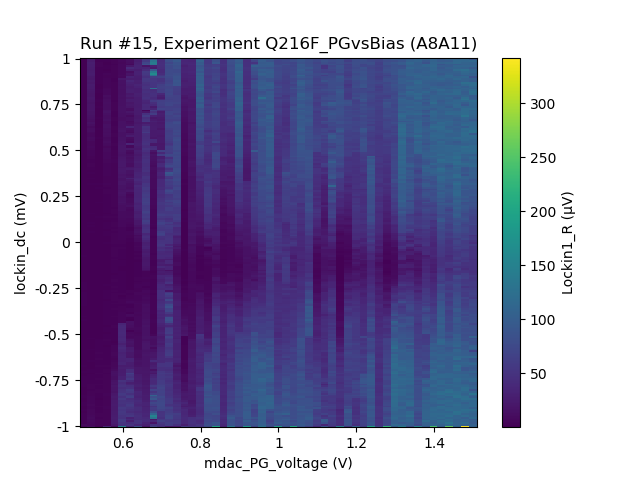

<IPython.core.display.Javascript object>


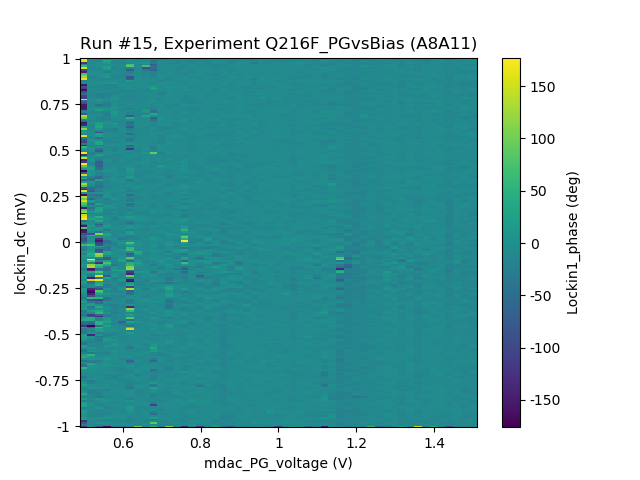

<IPython.core.display.Javascript object>


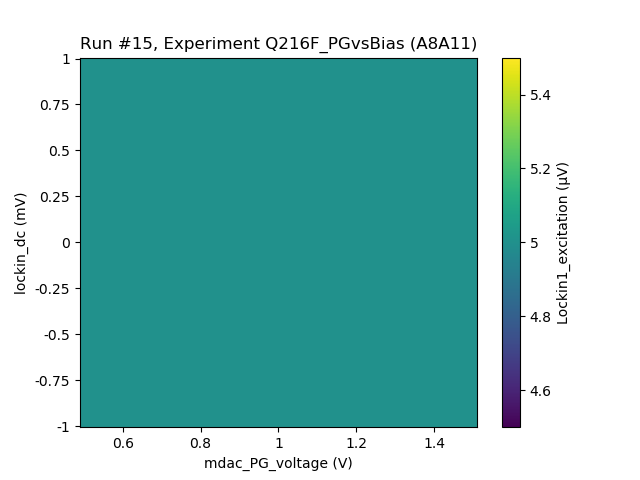

([<matplotlib.axes._subplots.AxesSubplot at 0x19e88d57978>,
  <matplotlib.colorbar.Colorbar at 0x19e8b333748>])

In [173]:
plot_by_id(15,cutoff_percentile=(0,10))

In [190]:
def setup():
    #set_mdac_in_safemode()
    #chs_safe(gate)
    #initialize(PG,TG1)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    mdac_PG_voltage(0)
    mdac_TG1_voltage(0.8)
    #mdac_TG2_voltage(0.5)
#    lockin_dc(10e-3)
    #gate.voltage(0.8)
#     key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    lockin_dc(-1e-3)
    lockin1.amplitude(5e-4)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(3)

def cleanup(): 
    #pass
    lockin1.amplitude(0)
    lockin_dc(0)
    #chs_safe(gate)
    #set_mdac_in_safemode()   
    mdac_PG_voltage(0)
    mdac_TG1_voltage(0)
    #mdac_TG2_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e6, Rseries=18e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    #V_meas = key2.volt()
    if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        time.sleep(3)
        #print(sr1.X())
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    Vac     = adder_atten*lockin1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = lockin1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain
    try:
        g = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g = 0
    #result  = current_dc, key_raw, g, L1X, L1Y, V_meas
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

#gate_values = np.linspace(2, 3, 151)
#gate_values = np.linspace(0, -0.75, 3)
# gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
    "Q216F_PGvsBias_sweep_TG_0.8V/D33A2",
    nest(
        sweep(mdac_PG_voltage, np.linspace(-2, 2, 601)),
        sweep(lockin_dc, np.linspace(-1e-3, 1e-3, 301)), # real voltage applied onto device
        measure(measure_acdc)
    ),
    setup,
    cleanup,
    live_plot=True
)

Starting experimental run with id: 26


In [114]:
try:
    float(1)/0
except ZeroDivisionError:
    print('a')

a


In [80]:
mdac_PG_voltage(0)

{'mdac_PG_voltage': 0}

In [56]:
mdac_TG1_voltage(0)

{'mdac_TG1_voltage': 0}

In [50]:
lockin_dc(1e-3)

{'lockin_dc': 0.001}

In [51]:
key1.volt()

-0.00040198757

In [156]:
PG.smc()

'close'

### Leakage test

In [215]:
initialize_leakage([TG2,TG1],[PG]) #first array the gates to set a voltage to, second the ones to open

In [216]:
def setup():
    #set_mdac_in_safemode()
    #chs_safe(gate)
    #initialize(PG,TG1)
    #ami_z.field(5.5)
    #mdac.ch49.voltage(-3.5)
    #mdac.ch57.dac_output('close')
    #mdac.ch57.smc('close')
    key1.NPLC(1)
    #source.voltage(0.8) 
    #mdac_bias_voltage(5e-3)
    #mdac_PG_voltage(0.5)
    mdac_TG2_voltage(0.5)
    mdac_TG1_voltage(0.1)
#    lockin_dc(10e-3)
    #gate.voltage(0.8)
#     key2.NPLC(1)
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    lockin_dc(0)
    lockin1.amplitude(0)     # 1e-2 attenuation so 10uV excitation when this is 1mV
    #ramp(sr1.sine_outdc, 10e-3*100, bias_ramp_stepsize, bias_ramp_delay) # attenuation 100
    #sr1.frequency(117)     # adder HPF cutoff is 15Hz
    #sr1.phase(0)
    #sr1.time_constant(.1)
    #ami_x.field(0)
    #ami_x.ramp_to(-0.2)
    time.sleep(3)

def cleanup(): 
    #pass
    lockin1.amplitude(0)
    lockin_dc(0)
    #chs_safe(gate)
    #set_mdac_in_safemode()   
    mdac_TG2_voltage(0)
    mdac_TG1_voltage(0)
    #mdac_TG2_voltage(0)
    #mdac.ch57.dac_output('open')
    #mdac.ch57.smc('open')
    #ivvi.dac3(0)
    #ivvi.dac2(0)
    #ivvi.dac1(0)    
    #yoko2.voltage(0)
    #ami_x.field(0)
    #ami_z.field(0)
    
@getter(('current', 'A'), ('raw_voltage_dc', 'V'), ('conductance', '2e^2/h'),
        ('Lockin1_X', 'V'), ('Lockin1_Y', 'V'), ('Lockin1_R', 'V'),
        ('Lockin1_phase', 'deg'), ('Lockin1_excitation', 'V'))
def measure_acdc(gain=1e8, Rseries=13e3, adder_atten=1e-2):
    time.sleep(0.08)
    #B_x = ami_x.field()
    #V_meas = key2.volt()
    if np.abs(np.abs(lockin1.sine_outdc())-0.05) < 2e-3: # make this range larger than distance btw two points
        #print('hi',sr1.sine_outdc(), sr1.sine_outdc()-0.05)
        time.sleep(3)
        #print(sr1.X())
    key_raw = key1.volt()
    current_dc = -key_raw/gain
    Vac     = adder_atten*lockin1.amplitude()  #*np.sqrt(2)
    #SR860 amplitude is really amplitude, not rms voltage in contrast to SR830 -- but this shouldn't affect how g is calculated?
    L1P     = lockin1.P() # in this order because this gives lockin_x more time to stailize and allows a shorter sleeping time
    L1R     = lockin1.R()
    L1Y     = lockin1.Y()
    # the above lines (excluding time.sleep) take at least 75ms to execute. 
    L1X     = lockin1.X()
    current_ac = L1X/gain    
    try:
        g = 12906/(Vac/current_ac - Rseries) #[2e^2/h]
    except ZeroDivisionError:
        g = 0
    result  = current_dc, key_raw, g, L1X, L1Y, L1R, L1P, Vac
    return result

#gate_values = np.linspace(0, 5, 401)
#gate_values = np.linspace(0, -0.75, 3)
# gate_values = np.append(gate_values,gate_values[::-1])

result = do_experiment(
    "Q216F_TG2_leakage_test_TG1_0.25V/C26C20",
    nest(
        sweep(mdac_TG2_voltage, np.linspace(0.5, 1.5, 101)),
        measure(measure_acdc)
    ),
    setup,
    cleanup,
    live_plot=True
)

Starting experimental run with id: 38
